# 7. Remedios y métodos robustos

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import statsmodels.api as sm
from statsmodels.robust.norms import HuberT, TukeyBiweight

from sklearn.utils import resample

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '../Data/'

X = np.load(path + 'X_def2.dat', allow_pickle= True)
B = np.load(path + 'B_def2.dat', allow_pickle= True)
Y = np.load(path + 'Y_def2.dat', allow_pickle= True)

In [4]:
result =  sm.load(path + 'ols_def2_results.pickle')

In [5]:
with open("../Data/regressor_columns_def2.pickle", "rb") as fp:   #Pickling
...   regressor_columns_def = pickle.load(fp)

## 7.1 HC0–HC3: Correcciones para heterocedasticidad

En un modelo de regresión lineal clásica (OLS), se asume que los errores $\varepsilon_i$ tienen varianza constante. Cuando este supuesto no se cumple (es decir, hay heterocedasticidad, como es nuestro caso), los coeficientes estimados $ \hat{\beta} $ siguen siendo insesgados,  
pero sus errores estándar son incorrectos, lo que invalida:

- Las pruebas t y F (significancia estadística)
- Los intervalos de confianza
- La inferencias sobre los coeficientes

Para corregir este problema, se usan errores estándar robustos a la heterocedasticidad, conocidos como correcciones HC (Heteroskedasticity-Consistent).

Estas correcciones fueron propuestas por White (1980) y luego refinadas por otros autores.  
Todas ajustan la matriz de covarianza de los coeficientes estimados, de forma que los errores estándar sean robustos.

$$
\widehat{Var}(\hat{\beta}) = (X'X)^{-1} X' \widehat{\Omega} X (X'X)^{-1}
$$

Donde $ \widehat{\Omega} $ cambia según la versión HC.

Las correcciones posibles y su uso recomendado se encuentra en la siguiente tabla:

| **Tipo** | **Nombre** | **Definición del peso $ \widehat{\Omega}_{ii} $** | **Descripción / Uso recomendado** |
|-----------|-------------|--------------------------------------|----------------------------------|
| **HC0** | White (1980) | $e_i^2 $ | Versión básica de White. Corrige la varianza usando los residuos al cuadrado sin ningún ajuste. |
| **HC1** | MacKinnon & White (1985) | $ \frac{n}{n - k} e_i^2 $ | Ajusta por tamaño de muestra y número de parámetros. Es el **más usado por defecto** en `statsmodels`. |
| **HC2** | Long & Ervin (2000) | $ \frac{e_i^2}{1 - h_{ii}} $ | Corrige además por la **influencia de cada observación** (leverage). Recomendado para muestras medianas. |
| **HC3** | Davidson & MacKinnon (1993) | $ \frac{e_i^2}{(1 - h_{ii})^2} $ | Versión más conservadora (mayores errores estándar). Ideal para muestras pequeñas o presencia de outliers. |

Donde:
- $ e_i $: residuo del modelo para la observación *i*.  
- $ h_{ii} $: valor diagonal de la matriz de “hat values” (influencia de cada observación).  
- $ n $: número de observaciones.  
- $ k $: número de parámetros estimados.

---
En base a lo anterior, calculamos nuestros modelos robustos, sabiendo que los coeficientes no cambiaran, la afectación principal será al error estandar.

In [6]:
print("\nModelos con corrección robusta a heterocedasticidad: HCO")
robust_model = result.get_robustcov_results(cov_type='HC0')
print(f"\n=== Resultados con HC0 ===")
robust_model.summary()


Modelos con corrección robusta a heterocedasticidad: HCO

=== Resultados con HC0 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1564.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:02:10   Log-Likelihood:                 1543.2
No. Observations:                2796   AIC:                            -3064.
Df Residuals:                    2785   BIC:                            -2999.
Df Model:                          10                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1001      0.470     -0.213      0.831      -1.022       0.822
x1             0.0848      0.003     24.357      0.000       0.078       0.092
x2             0.3541      0.015     23.815      0.000       0.325       0.383
x3             0.0003   2.14e-05     11.984      0.000       0.000       0.000
x4             0.0024      0.000     13.207      0.000       0.002       0.003
x5             0.1852      0.011     17.247      0.000       0.164       0.206
x6             0.0022      0.000     10.514      0.000       0.002       0.003
x7            -0.0338      0.008     -4.117      0.000      -0.050      -0.018
x8            -0.0007      0.000     -3.127      0.002      -0.001      -0.000
x9            -0.0335      0.007     -4.620      0.000      -0.048      -0.019
x10           -0.0704      0.006    -11.633      0.000      -0.082      -0.059
==============================================================================
Omnibus:                      262.543   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              714.317
Skew:                          -0.518   Prob(JB):                    7.73e-156
Kurtosis:                       5.249   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
HC0_se = robust_model.bse

In [8]:
HC0_ci = robust_model.conf_int(alpha=0.05)

HC0_width = HC0_ci[:,1] - HC0_ci[:,0]

In [9]:
print("\nModelos con corrección robusta a heterocedasticidad: HC1")
robust_model = result.get_robustcov_results(cov_type='HC1')
print(f"\n=== Resultados con HC1 ===")
robust_model.summary()


Modelos con corrección robusta a heterocedasticidad: HC1

=== Resultados con HC1 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1558.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:02:10   Log-Likelihood:                 1543.2
No. Observations:                2796   AIC:                            -3064.
Df Residuals:                    2785   BIC:                            -2999.
Df Model:                          10                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1001      0.471     -0.212      0.832      -1.024       0.824
x1             0.0848      0.003     24.309      0.000       0.078       0.092
x2             0.3541      0.015     23.768      0.000       0.325       0.383
x3             0.0003   2.15e-05     11.960      0.000       0.000       0.000
x4             0.0024      0.000     13.181      0.000       0.002       0.003
x5             0.1852      0.011     17.213      0.000       0.164       0.206
x6             0.0022      0.000     10.493      0.000       0.002       0.003
x7            -0.0338      0.008     -4.108      0.000      -0.050      -0.018
x8            -0.0007      0.000     -3.121      0.002      -0.001      -0.000
x9            -0.0335      0.007     -4.611      0.000      -0.048      -0.019
x10           -0.0704      0.006    -11.610      0.000      -0.082      -0.059
==============================================================================
Omnibus:                      262.543   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              714.317
Skew:                          -0.518   Prob(JB):                    7.73e-156
Kurtosis:                       5.249   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
HC1_se = robust_model.bse

In [11]:
HC1_ci = robust_model.conf_int(alpha=0.05)

HC1_width = HC1_ci[:,1] - HC1_ci[:,0]

In [12]:
print("\nModelos con corrección robusta a heterocedasticidad: HC2")
robust_model = result.get_robustcov_results(cov_type='HC2')
print(f"\n=== Resultados con HC2 ===")
robust_model.summary()


Modelos con corrección robusta a heterocedasticidad: HC2

=== Resultados con HC2 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1558.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:02:10   Log-Likelihood:                 1543.2
No. Observations:                2796   AIC:                            -3064.
Df Residuals:                    2785   BIC:                            -2999.
Df Model:                          10                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1001      0.472     -0.212      0.832      -1.025       0.825
x1             0.0848      0.003     24.283      0.000       0.078       0.092
x2             0.3541      0.015     23.751      0.000       0.325       0.383
x3             0.0003   2.15e-05     11.941      0.000       0.000       0.000
x4             0.0024      0.000     13.146      0.000       0.002       0.003
x5             0.1852      0.011     17.202      0.000       0.164       0.206
x6             0.0022      0.000     10.477      0.000       0.002       0.003
x7            -0.0338      0.008     -4.103      0.000      -0.050      -0.018
x8            -0.0007      0.000     -3.114      0.002      -0.001      -0.000
x9            -0.0335      0.007     -4.605      0.000      -0.048      -0.019
x10           -0.0704      0.006    -11.605      0.000      -0.082      -0.059
==============================================================================
Omnibus:                      262.543   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              714.317
Skew:                          -0.518   Prob(JB):                    7.73e-156
Kurtosis:                       5.249   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
HC2_se = robust_model.bse

In [14]:
HC2_ci = robust_model.conf_int(alpha=0.05)

HC2_width = HC2_ci[:,1] - HC2_ci[:,0]

In [15]:
print("\nModelos con corrección robusta a heterocedasticidad: HC3")
robust_model = result.get_robustcov_results(cov_type='HC3')
print(f"\n=== Resultados con HC3 ===")
robust_model.summary()


Modelos con corrección robusta a heterocedasticidad: HC3

=== Resultados con HC3 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1551.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:02:10   Log-Likelihood:                 1543.2
No. Observations:                2796   AIC:                            -3064.
Df Residuals:                    2785   BIC:                            -2999.
Df Model:                          10                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1001      0.473     -0.212      0.832      -1.028       0.827
x1             0.0848      0.004     24.210      0.000       0.078       0.092
x2             0.3541      0.015     23.686      0.000       0.325       0.383
x3             0.0003   2.16e-05     11.898      0.000       0.000       0.000
x4             0.0024      0.000     13.084      0.000       0.002       0.003
x5             0.1852      0.011     17.157      0.000       0.164       0.206
x6             0.0022      0.000     10.440      0.000       0.002       0.003
x7            -0.0338      0.008     -4.089      0.000      -0.050      -0.018
x8            -0.0007      0.000     -3.101      0.002      -0.001      -0.000
x9            -0.0335      0.007     -4.591      0.000      -0.048      -0.019
x10           -0.0704      0.006    -11.577      0.000      -0.082      -0.059
==============================================================================
Omnibus:                      262.543   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              714.317
Skew:                          -0.518   Prob(JB):                    7.73e-156
Kurtosis:                       5.249   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
HC3_se = robust_model.bse

In [17]:
HC3_ci = robust_model.conf_int(alpha=0.05)

HC3_width = HC3_ci[:,1] - HC3_ci[:,0]

---
Finalmente, generamos una tabla con los errores estandares para cada coeficiente. Notamos que los 4 metodos arrojan resultados muy similares, lo cual es evidenciado en los p-valores, que sufren cambios insignificantes entre cada metodo, por lo que podemos mantener las decisiones hechas hasta el momento. 

In [18]:
# Tabla comparativa de errores estandar
comparison_se = pd.DataFrame({
    'HC0': HC0_se,
    'HC1': HC1_se,
    'HC2': HC2_se,
    'HC3': HC3_se
})

comparison_se

,HC0,HC1,HC2,HC3
0,0.470141,0.471068,0.471588,0.473041
1,0.003483,0.003489,0.003493,0.003504
2,0.014870,0.014900,0.014911,0.014951
3,0.000021,0.000021,0.000021,0.000022
4,0.000181,0.000181,0.000182,0.000183
5,0.010738,0.010759,0.010766,0.010794
6,0.000212,0.000212,0.000212,0.000213
7,0.008223,0.008239,0.008251,0.008278
8,0.000227,0.000227,0.000228,0.000229
9,0.007251,0.007265,0.007273,0.007296


In [25]:
# Tabla comparativa de intervalos de confianza
def my_function(row):
      # Example: Sum of elements in the row
      return '({0:.5f} ; {1:.5f})'.format(row[0], row[1])

comparison_IC = pd.DataFrame({
    'HC0': np.apply_along_axis(my_function, 1, HC0_ci),
    'HC1': np.apply_along_axis(my_function, 1, HC1_ci),
    'HC2': np.apply_along_axis(my_function, 1, HC2_ci),
    'HC3': np.apply_along_axis(my_function, 1, HC3_ci)
})

comparison_IC

,HC0,HC1,HC2,HC3
0,(-1.02194 ; 0.82178),(-1.02376 ; 0.82360),(-1.02478 ; 0.82462),(-1.02763 ; 0.82747)
1,(0.07800 ; 0.09165),(0.07798 ; 0.09167),(0.07798 ; 0.09167),(0.07796 ; 0.09170)
2,(0.32498 ; 0.38330),(0.32492 ; 0.38336),(0.32490 ; 0.38338),(0.32482 ; 0.38346)
3,(0.00021 ; 0.00030),(0.00021 ; 0.00030),(0.00021 ; 0.00030),(0.00021 ; 0.00030)
4,(0.00203 ; 0.00274),(0.00203 ; 0.00274),(0.00203 ; 0.00275),(0.00203 ; 0.00275)
5,(0.16414 ; 0.20625),(0.16409 ; 0.20629),(0.16408 ; 0.20630),(0.16403 ; 0.20636)
6,(0.00181 ; 0.00264),(0.00181 ; 0.00264),(0.00181 ; 0.00264),(0.00181 ; 0.00264)
7,(-0.04997 ; -0.01773,(-0.05001 ; -0.01769,(-0.05003 ; -0.01767,(-0.05008 ; -0.01762
8,(-0.00115 ; -0.00026,(-0.00115 ; -0.00026,(-0.00116 ; -0.00026,(-0.00116 ; -0.00026
9,(-0.04771 ; -0.01928,(-0.04774 ; -0.01925,(-0.04776 ; -0.01923,(-0.04780 ; -0.01919


In [20]:
# Tabla comparativa de amplitud de intervalos de confianza
comparison_width = pd.DataFrame({
    'HC0': HC0_width,
    'HC1': HC1_width,
    'HC2': HC2_width,
    'HC3': HC3_width
})

comparison_width

,HC0,HC1,HC2,HC3
0,1.843720,1.847357,1.849394,1.855093
1,0.013658,0.013684,0.013699,0.013740
2,0.058316,0.058431,0.058474,0.058634
3,0.000084,0.000084,0.000084,0.000085
4,0.000709,0.000711,0.000713,0.000716
5,0.042110,0.042193,0.042220,0.042330
6,0.000830,0.000831,0.000833,0.000836
7,0.032247,0.032310,0.032355,0.032465
8,0.000889,0.000891,0.000893,0.000897
9,0.028434,0.028490,0.028522,0.028611


## 7.2 RLM: Modelos robustos con funciones Huber/Tukey

En muchos datasets reales (como el analizado), existen:

- Outliers estructurales (casas atípicamente grandes o pequeñas).  
- Errores de medición o distribuciones asimétricas.

La Regresión Robusta (RLM) busca reducir el efecto de estos puntos extremos, de modo que el modelo capture mejor la tendencia central de los datos.

### 7.2.1 Función de pérdida de Huber

La función de Huber combina las ventajas de OLS y de la regresión absoluta (L1):

$$
\rho(u) =
\begin{cases}
\frac{1}{2}u^2 & \text{si } |u| \leq c \\
c(|u| - \frac{1}{2}c) & \text{si } |u| > c
\end{cases}
$$

Donde:
- $u = \frac{y_i - \hat{y}_i}{\sigma}$ es el residuo estandarizado.  
- $c$ es un parámetro de sensibilidad (típicamente \(c = 1.345\)).

De esta forma para residuos pequeños, Huber se comporta igual que OLS (cuadrático). Pero, para residuos grandes, estos se penalizan linealmente (como L1), reduciendo la influencia de outliers.

A continuación calculamos nuestro modelo con Huber:

In [35]:
# Ajustar modelo RLM con Huber (Regresión Lineal Robusta)
rlm_model = sm.RLM(Y, X, M=HuberT())  
rlm_results = rlm_model.fit()

print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 2796
Model:                            RLM   Df Residuals:                     2785
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 09 Nov 2025                                         
Time:                        19:25:33                                         
No. Iterations:                    23                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0822      0.383     -0.215      0.8

---
Por otra parte, la función de Tukey o biweight penaliza los residuos de forma suave, y llega incluso a eliminar completamente la influencia de los puntos demasiado lejanos.

$$
\rho(u) =
\begin{cases}
\frac{c^2}{6} \left[ 1 - \left( 1 - \left(\frac{u}{c}\right)^2 \right)^3 \right] & \text{si } |u| \leq c \\
\frac{c^2}{6} & \text{si } |u| > c
\end{cases}
$$

Donde:

- $u = \frac{y_i - \hat{y}_i}{\sigma}$ es el residuo estandarizado.  
- $c$ es un parámetro de corte que determina qué tan agresivo es el recorte de outliers (típicamente $c = 4.685$).


In [38]:
# Ajustar modelo RLM con Tukey (Regresión Lineal Robusta)
tukey_model = sm.RLM(Y, X, M=TukeyBiweight()) 
tukey_results = tukey_model.fit()

print(tukey_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 2796
Model:                            RLM   Df Residuals:                     2785
Method:                          IRLS   Df Model:                           10
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 09 Nov 2025                                         
Time:                        19:27:16                                         
No. Iterations:                    21                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0333      0.385     -0.086      0.9

Observamos que aunque encontramos una leve variación en los pesos de los coeficiente, siguen manteniendo significancia (con excepción del intercepto).

In [39]:
comparison_params = pd.DataFrame({
    'OLS': result.params,
    'Huber': rlm_results.params,
    'Tukey': tukey_results.params
})

comparison_params

,OLS,Huber,Tukey
0,-0.100081,-0.082181,-0.033274
1,0.084825,0.083393,0.082547
2,0.354140,0.363089,0.368069
3,0.000257,0.000261,0.000260
4,0.002389,0.002337,0.002330
5,0.185191,0.192930,0.196364
6,0.002225,0.002114,0.002113
7,-0.033850,-0.032773,-0.031491
8,-0.000709,-0.000615,-0.000660
9,-0.033496,-0.026724,-0.025220


---
Finalmente, analizamos el peso asignado a los outlier, de acuerdo al tipo de metodo. Vemos que OLS asigna el mismo peso a cada observación, pero huber y tukey asignan menos peso según este se va alejando de la media. En el caso de Tukey, vemos que esta inflencia llega a ser nula, y empieza a disminuir la influencia suavemente desde el comienzo. Huber en cambio, toma cierta distancia antes de empezar a afectar la influencia, sin llegar a eliminarla completamente.

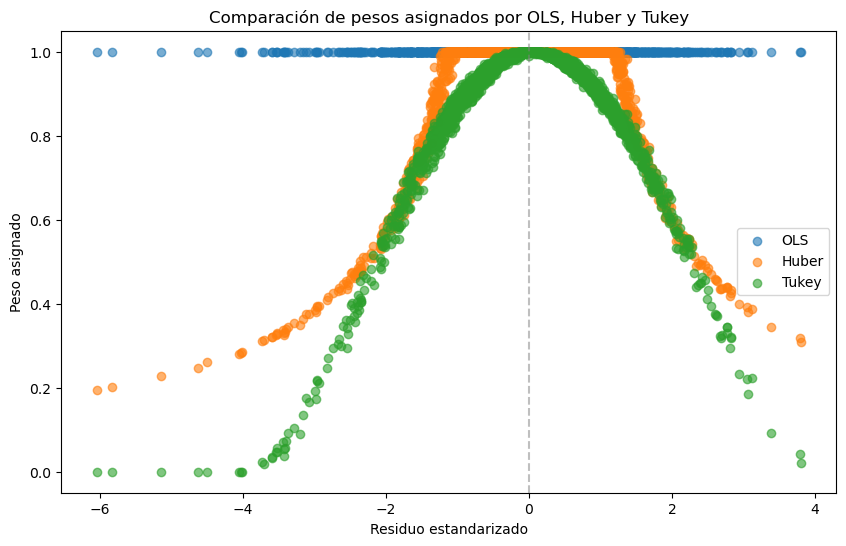

In [51]:

# Modelo RLM con Huber
weights_huber = rlm_results.weights

# Modelo RLM con Tukey (biweight)
weights_tukey = tukey_results.weights

# Residuo estandarizado
resid_std = (Y.flatten() - result.fittedvalues) / np.std(result.resid)

# Construir DataFrame comparativo
weights_df = pd.DataFrame({
    'Residuo estandarizado': resid_std,
    'Peso_Huber': weights_huber,
    'Peso_Tukey': weights_tukey,
    'Peso_OLS': 1  # OLS asigna peso uniforme
})

# Visualización
plt.figure(figsize=(10,6))
plt.scatter(weights_df['Residuo estandarizado'], weights_df['Peso_OLS'], label='OLS', alpha=0.6)
plt.scatter(weights_df['Residuo estandarizado'], weights_df['Peso_Huber'], label='Huber', alpha=0.6)
plt.scatter(weights_df['Residuo estandarizado'], weights_df['Peso_Tukey'], label='Tukey', alpha=0.6)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.title("Comparación de pesos asignados por OLS, Huber y Tukey")
plt.xlabel("Residuo estandarizado")
plt.ylabel("Peso asignado")
plt.legend()
plt.show()

## 7.3 Bootstrap

Bootstrap se aprovecha de la ley de los grandes número para estimar los coeficientes y estadísticos del modelo sin asumir una distribución teórica para los datos.

Consiste en una serie de muestreos aleatorios con reemplazo del set de entrenamiento, una gran cantidad de veces (n > 1000). Si los datos observados son una buena representación de la población, entonces remuestrear con reemplazo de ellos puede simular nuevas "muestras" de esa población.

En cada iteración se ajusta un modelo de acuerdo al muestreo realizado. Los coeficientes de cada iteración se guardan. Tras finalizar, el coeficiente correspondiente de cada variable corresponderá al promedio de los n coeficientes obtenidos y el error estandar será igual a la desviación estandar de cada variable. 

 La colección de estimadores:
   $$
   \{ \hat{\theta}^*_1, \hat{\theta}^*_2, ..., \hat{\theta}^*_B \}
   $$
   representa una aproximación empírica a la distribución del estimador.

**Error estándar (EE):**
 $$
 SE(\hat{\theta}) = \sqrt{\frac{1}{B-1} \sum_{b=1}^B \left(\hat{\theta}^*_b - \overline{\hat{\theta}^*}\right)^2 }
 $$
- **Intervalo de confianza (95%):**
 percentiles 2.5% y 97.5% de la distribución bootstrap.

In [52]:
# Parámetros del bootstrap
n_bootstraps = 1000
coefficients = []

# Loop de bootstrap
for i in range(n_bootstraps):
    # Re-muestreo con reemplazo
    X_res, y_res = resample(X, Y, replace=True, random_state=i)
    
    # Ajustar modelo OLS
    model = sm.OLS(y_res, X_res).fit()
    
    # Guardar coeficientes
    coefficients.append(model.params)

# Convertir a DataFrame
boot_df = pd.DataFrame(coefficients, columns=['const'] + regressor_columns_def)

# Estadísticos del bootstrap
boot_summary = pd.DataFrame({
    "Media": boot_df.mean(),
    "Desviación Std": boot_df.std(),
    "IC 2.5%": boot_df.quantile(0.025),
    "IC 97.5%": boot_df.quantile(0.975)
})

print("\nResultados del Bootstrap (1000 réplicas):")
print(boot_summary)


Resultados del Bootstrap (1000 réplicas):
                               Media  Desviación Std   IC 2.5%  IC 97.5%
const                      -0.106994        0.468346 -1.000256  0.799681
Overall Qual                0.084599        0.003603  0.077854  0.091957
Gr Liv Area                 0.354547        0.015036  0.324774  0.383495
Garage Area                 0.000256        0.000021  0.000217  0.000298
Year Built                  0.002391        0.000179  0.002046  0.002721
1st Flr SF                  0.185198        0.010514  0.164042  0.205876
Year Remod/Add              0.002227        0.000212  0.001820  0.002661
Full Bath                  -0.034009        0.008363 -0.050566 -0.018575
Garage Yr Blt              -0.000710        0.000229 -0.001169 -0.000243
Kitchen Qual_TA            -0.033708        0.006989 -0.046987 -0.020318
Fireplace Qu_Sin categoria -0.070356        0.006199 -0.082440 -0.058049


---
Analizando la distribución de cada coeficiente y comparandolo con el ols original, observamos resultados bastante similares y una distribución aproximadamente normal en la mayoría de los coeficientes.

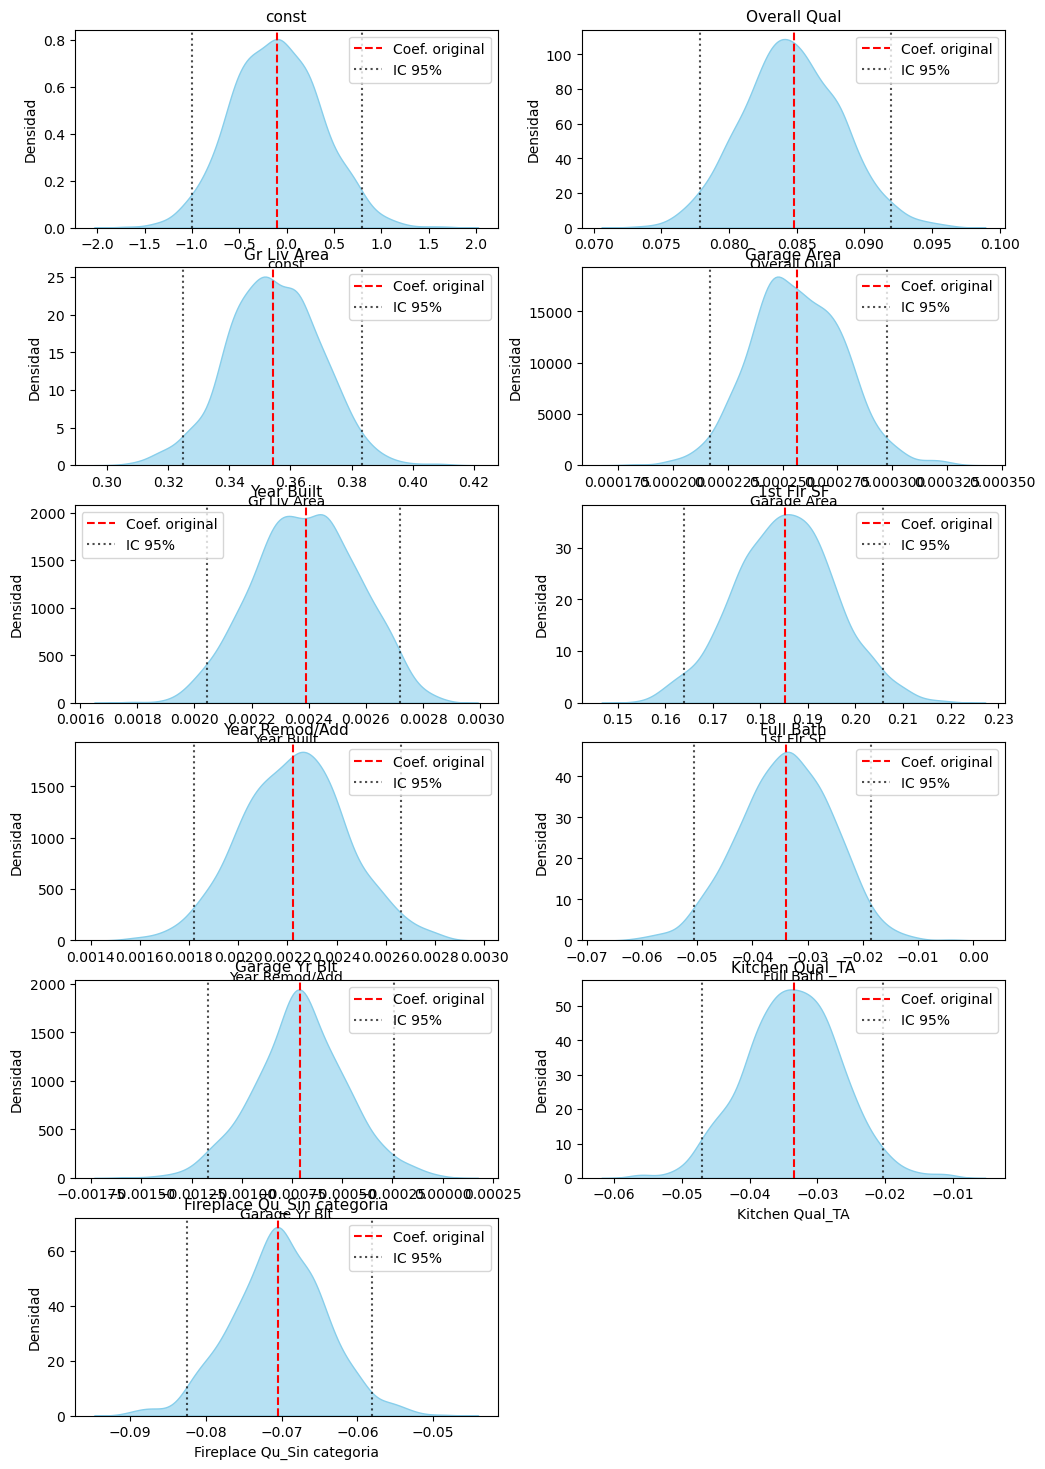

In [61]:

n_vars = len(boot_df.columns)
n_cols = 2
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()

# --- Graficar distribuciones ---
for i, col in enumerate(boot_df.columns):
    sns.kdeplot(boot_df[col], fill=True, color='skyblue', alpha=0.6, ax=axes[i])
    
    # Línea del coeficiente original
    axes[i].axvline(x=result.params[i], color='red', linestyle='--', label='Coef. original')
    
    # Intervalo de confianza 95%
    ci_lower, ci_upper = boot_df[col].quantile([0.025, 0.975])
    axes[i].axvline(ci_lower, color='black', linestyle=':', alpha=0.7, label='IC 95%')
    axes[i].axvline(ci_upper, color='black', linestyle=':', alpha=0.7)
    
    axes[i].set_title(f"{col}", fontsize=11)
    axes[i].set_ylabel("Densidad")
    axes[i].legend()

# --- Eliminar subplots vacíos ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

## 7.4 Tabla Comparativa

A continuación, mostramos las tablas comparativas entre los modelos obtenidos para los estadisticos principales.

### 7.4.1 Error Estándar

Observamos que el metodo HC3 entrega en la mayoría de los casos el error estándar más alto, consistente con lo esperado, junto con Bootstrap. Esto nos lleva a pensar que OLS subestima un poco el error estándar de los errores, probablemente por una asunción erronea como puede ser normalidad o homocedasticidad.

In [62]:
comparison_se = pd.DataFrame({
    'OLS': result.bse,
    'HC3_SE': HC3_se,
    'Bootstrap_SE': boot_df.std()
})

comparison_se

,OLS,HC3_SE,Bootstrap_SE
const,0.415762,0.473041,0.468346
Overall Qual,0.003236,0.003504,0.003603
Gr Liv Area,0.013835,0.014951,0.015036
Garage Area,0.000018,0.000022,0.000021
Year Built,0.000166,0.000183,0.000179
1st Flr SF,0.010521,0.010794,0.010514
Year Remod/Add,0.000187,0.000213,0.000212
Full Bath,0.007231,0.008278,0.008363
Garage Yr Blt,0.000199,0.000229,0.000229
Kitchen Qual_TA,0.007037,0.007296,0.006989


### 7.4.2 Amplitud de intervalos de confianza

In [63]:
ols_ci = result.conf_int(alpha=0.05)

ols_width = ols_ci[:,1] - ols_ci[:,0]

ols_width

array([1.63046717e+00, 1.26917608e-02, 5.42539810e-02, 6.97743526e-05,
       6.49404733e-04, 4.12601045e-02, 7.34213383e-04, 2.83567547e-02,
       7.81834568e-04, 2.75949480e-02, 2.43701441e-02])

In [65]:
bootstrap_width = boot_df.quantile(0.975) - boot_df.quantile(0.025)

bootstrap_width

const                         1.799937
Overall Qual                  0.014103
Gr Liv Area                   0.058722
Garage Area                   0.000081
Year Built                    0.000675
1st Flr SF                    0.041834
Year Remod/Add                0.000841
Full Bath                     0.031991
Garage Yr Blt                 0.000926
Kitchen Qual_TA               0.026669
Fireplace Qu_Sin categoria    0.024391
dtype: float64

In [72]:
comparison_ICwidth = pd.DataFrame({
    'OLS': ols_width,
    'HC3': ols_width,
    'Bootstrap': bootstrap_width
})

comparison_ICwidth

,OLS,HC3,Bootstrap
const,1.630467,1.630467,1.799937
Overall Qual,0.012692,0.012692,0.014103
Gr Liv Area,0.054254,0.054254,0.058722
Garage Area,0.000070,0.000070,0.000081
Year Built,0.000649,0.000649,0.000675
1st Flr SF,0.041260,0.041260,0.041834
Year Remod/Add,0.000734,0.000734,0.000841
Full Bath,0.028357,0.028357,0.031991
Garage Yr Blt,0.000782,0.000782,0.000926
Kitchen Qual_TA,0.027595,0.027595,0.026669


En cambio, Boostrap entrega en su mayoría el intervalo de confianza más amplio. Esto podría indicar que la presunción de normalidad podría no ser correcta, ya que Bootstrap entrega resultados más emperícos, sin necesidad de asumir una distribución de los errores.

### 7.4.3 Comparación de coeficientes

In [69]:
comparison_coeff = pd.DataFrame({
    'OLS': result.params,
    'HC3': robust_model.params,
    'RLM': rlm_results.params,
    'Bootstrap': boot_df.mean()
})

comparison_coeff

,OLS,HC3,RLM,Bootstrap
const,-0.100081,-0.100081,-0.082181,-0.106994
Overall Qual,0.084825,0.084825,0.083393,0.084599
Gr Liv Area,0.354140,0.354140,0.363089,0.354547
Garage Area,0.000257,0.000257,0.000261,0.000256
Year Built,0.002389,0.002389,0.002337,0.002391
1st Flr SF,0.185191,0.185191,0.192930,0.185198
Year Remod/Add,0.002225,0.002225,0.002114,0.002227
Full Bath,-0.033850,-0.033850,-0.032773,-0.034009
Garage Yr Blt,-0.000709,-0.000709,-0.000615,-0.000710
Kitchen Qual_TA,-0.033496,-0.033496,-0.026724,-0.033708


Finalmente, al comparar los coeficientes, vemos que bootstrap arroja resultados muy similares a HC3 y OLS. Los coeficientes arrojados por OLS no dependen de supuestos como normalidad o homocedasticidad, por lo que tiene sentido que sea similar a lo entregado por Bootstrap. RLM presenta diferencias más notables, donde las mayores la vemos en el caso de la variable 'Kitchen Qual_TA', 'Garage Yr Blt' y 'Fireplace Qu_Sin categoria'.

Esto puede deberse a que, al eliminar influencia de outliers en estas variables, RLM le da menos significancia que la que le da OLS.